In [1]:
#import necessary libs
import os

import keras_cv
import keras_core as keras
from keras_core import layers

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend


Configuration

refer this for EDA - https://www.kaggle.com/code/aritrag/eda-train-csv

In [2]:
class Config:
    SEED = 69
    IMAGE_SIZE = [256,256]
    BATCH_SIZE=32
    EPOCHS = 5
    TARGET_COLS = [
        "bowel_injury", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high"
    ]
    AUTOTUNE = tf.data.AUTOTUNE
    
config = Config()

Reproducibility

We would want this notebook to have reproducible results. Here we set the seed for all the random algorithms so that we can reproduce the experiments each time exactly the same way.



In [3]:
keras.utils.set_random_seed(seed=config.SEED)

The dataset provided in the competition consists of DICOM images. We will not be training on the DICOM images, rather would work on PNG image which are extracted from the DICOM format.

A helpful resource on the conversion of DICOM to PNG - https://www.kaggle.com/code/radek1/how-to-process-dicom-images-to-pngs

In [4]:
BASE_PATH = f'/kaggle/input/rsna-atd-512x512-png-v2-dataset'

train.csv contains metadata

In [5]:
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...,512,512
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...,512,512
2,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,364,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...,512,512
3,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,365,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...,512,512
4,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,366,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...,512,512


In [6]:
df["image_path"] = f"{BASE_PATH}/train_images"\
                    + "/" + df.patient_id.astype(str)\
                    + "/" + df.series_id.astype(str)\
                    + "/" + df.instance_number.astype(str) +".png"

df = df.drop_duplicates()

In [7]:
df

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
2,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,364,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
3,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,365,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
4,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,366,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13010,9632,1,0,0,1,1,0,0,1,0,...,1,0,0,1,3750,155,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
13011,9632,1,0,0,1,1,0,0,1,0,...,1,0,0,1,3750,156,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
13012,9632,1,0,0,1,1,0,0,1,0,...,1,0,0,1,3750,157,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
13013,9632,1,0,0,1,1,0,0,1,0,...,1,0,0,1,3750,158,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512


We split the training dataset into train and validation. This is a common practise in the Machine Learning pipelines. We not only want to train our model, but also want to validate it's training.

A small catch here is that the training and validation data should have an aligned data distribution. Here we handle that by grouping the lables and then splitting the dataset. This ensures an aligned data distribution between the training and the validation splits.

In [8]:
#Split_group function ""
def split_group(group,test_size=0.2):
    if len(group)==1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame()
                                                                             ,group)
    else:
        return train_test_split(group,test_size=test_size,random_state=69)
    


In [9]:
#initialize 2 empty dfs for train and val

train_data = pd.DataFrame()
val_data = pd.DataFrame()

In [10]:
# Iterate through the groups and split them, handling single-sample groups
for _, group in df.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data,train_group],ignore_index=True)
    val_data = pd.concat([val_data,val_group],ignore_index=True)
    
print(train_data.shape)
print(val_data.shape)

(9612, 21)
(2417, 21)


Data Pipeline /w tf.data
'

Here we build the data pipeline using tf.data. Using tf.data we can map out data to an augmentation pipeline simple by using the map API.

Adding augmentations to the data pipeline is as simple as adding a layer into the list of layers that the Augmenter processes.

Reference: https://keras.io/api/keras_cv/layers/augmentation/

In [11]:
#from keras_cv.augment.preprocess.augment import RandomFlip
from tensorflow.keras.layers.experimental import preprocessing

def decode_image_and_label(image_path, label):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0
    
    label = tf.cast(label, tf.float32)
    #         bowel       fluid       kidney      liver       spleen
    labels = (label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])
    
    return (image, labels)


def apply_augmentation(images, labels):
    augmenter = keras.Sequential(
        
        layers=[
            keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
            keras_cv.layers.RandomCutout(height_factor=0.2, width_factor=0.2),
            
        ]
    )
    aug = augmenter(images)
    return (aug, labels)

def aug(image,labels):
    image = preprocessing.Rescaling(1.0 / 255)(image)  # Rescale pixel values
    image = preprocessing.RandomFlip(mode="horizontal_and_vertical")(image)
    image = preprocessing.RandomRotation(factor=0.2)(image)
    #image = preprocessing.RandomZoom(height_factor=(0.8, 1.2), width_factor=(0.8, 1.2))(image)
    #image = preprocessing.RandomContrast(factor=0.2)(image)
    image = preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2)(image)
    return (image, labels)

In [12]:
def build_dataset(image_paths, labels):
    ds = (
        tf.data.Dataset.from_tensor_slices((image_paths, labels))
        .map(decode_image_and_label, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .map(aug, num_parallel_calls=config.AUTOTUNE)
        .prefetch(config.AUTOTUNE)
    )
    return ds

In [13]:
paths  = train_data.image_path.tolist()
labels = train_data[config.TARGET_COLS].values

ds = build_dataset(image_paths=paths, labels=labels)
images, labels = next(iter(ds))
images.shape, [label.shape for label in labels]

(TensorShape([32, 256, 256, 3]),
 [TensorShape([32, 1]),
  TensorShape([32, 1]),
  TensorShape([32, 3]),
  TensorShape([32, 3]),
  TensorShape([32, 3])])

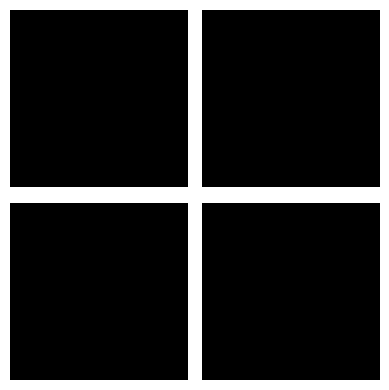

In [14]:
keras_cv.visualization.plot_image_gallery(
    images=images,
    value_range=(0,1),
    rows=2,
    cols=2
)

BUILD MODEL

In [15]:
def build_model(warmup_steps, decay_steps):
    # Define Input
    inputs = keras.Input(shape=config.IMAGE_SIZE + [3,], batch_size=config.BATCH_SIZE)
    



    # Define Backbone
    backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xl_backbone_coco")
    backbone.include_rescaling = False
    
    class Backbone(keras.Layer):
        def call(self,inputs):
            return backbone(inputs)
    x = Backbone()(inputs)
    
    # GAP to get the activation maps
    gap = keras.layers.GlobalAveragePooling2D()
    x = gap(x)

    # Define 'necks' for each head
    x_bowel = keras.layers.Dense(32, activation='silu')(x)
    x_extra = keras.layers.Dense(32, activation='silu')(x)
    x_liver = keras.layers.Dense(32, activation='silu')(x)
    x_kidney = keras.layers.Dense(32, activation='silu')(x)
    x_spleen = keras.layers.Dense(32, activation='silu')(x)

    # Define heads
    out_bowel = keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel) # use sigmoid to convert predictions to [0-1]
    out_extra = keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra) # use sigmoid to convert predictions to [0-1]
    out_liver = keras.layers.Dense(3, name='liver', activation='softmax')(x_liver) # use softmax for the liver head
    out_kidney = keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney) # use softmax for the kidney head
    out_spleen = keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen) # use softmax for the spleen head
    
    # Concatenate the outputs
    outputs = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    # Create model
    print("[INFO] Building the model...")
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # Cosine Decay
    cosine_decay = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4,
        decay_steps=decay_steps,
        alpha=0.0,
        warmup_target=1e-3,
        warmup_steps=warmup_steps,
    )

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=cosine_decay)
    loss = {
        "bowel":keras.losses.BinaryCrossentropy(),
        "extra":keras.losses.BinaryCrossentropy(),
        "liver":keras.losses.CategoricalCrossentropy(),
        "kidney":keras.losses.CategoricalCrossentropy(),
        "spleen":keras.losses.CategoricalCrossentropy(),
    }
    metrics = {
        "bowel":["accuracy"],
        "extra":["accuracy"],
        "liver":["accuracy"],
        "kidney":["accuracy"],
        "spleen":["accuracy"],
    }
    print("[INFO] Compiling the model...")
    model.compile(
        optimizer=optimizer,
      loss=loss,
      metrics=metrics
    )
    
    return model

In [16]:
# get image_paths and labels
print("[INFO] Building the dataset...")
train_paths = train_data.image_path.values; train_labels = train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = val_data.image_path.values; valid_labels = val_data[config.TARGET_COLS].values.astype(np.float32)

# train and valid dataset
train_ds = build_dataset(image_paths=train_paths, labels=train_labels)
val_ds = build_dataset(image_paths=valid_paths, labels=valid_labels)

total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"{total_train_steps=}")
print(f"{warmup_steps=}")
print(f"{decay_steps=}")

[INFO] Building the dataset...
total_train_steps=48160
warmup_steps=4816
decay_steps=43344


In [17]:
# build the model
print("[INFO] Building the model...")
model = build_model(warmup_steps, decay_steps)

# train
print("[INFO] Training...")
history = model.fit(
    train_ds,
    epochs=config.EPOCHS,
    validation_data=val_ds,
)

[INFO] Building the model...
124353200/124353200 [==============================] - 1s 0us/step
[INFO] Building the model...
[INFO] Compiling the model...
[INFO] Training...
Epoch 1/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 266s 786ms/step - bowel_accuracy: 0.8595 - extra_accuracy: 0.7826 - kidney_accuracy: 0.7159 - liver_accuracy: 0.6675 - loss: 3.2024 - spleen_accuracy: 0.6042 - val_bowel_accuracy: 0.5205 - val_extra_accuracy: 0.6967 - val_kidney_accuracy: 0.8113 - val_liver_accuracy: 0.8697 - val_loss: 5.0667 - val_spleen_accuracy: 0.6773
Epoch 2/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 165s 520ms/step - bowel_accuracy: 0.6510 - extra_accuracy: 0.9129 - kidney_accuracy: 0.7747 - liver_accuracy: 0.6880 - loss: 4.2064 - spleen_accuracy: 0.6092 - val_bowel_accuracy: 0.5205 - val_extra_accuracy: 0.6967 - val_kidney_accuracy: 0.8113 - val_liver_accuracy: 0.8697 - val_loss: 4.5398 - val_spleen_accuracy: 0.6773
Epoch 3/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 202s 519ms/step - bowel_accuracy: 0.5502 - extra_accuracy: 0.

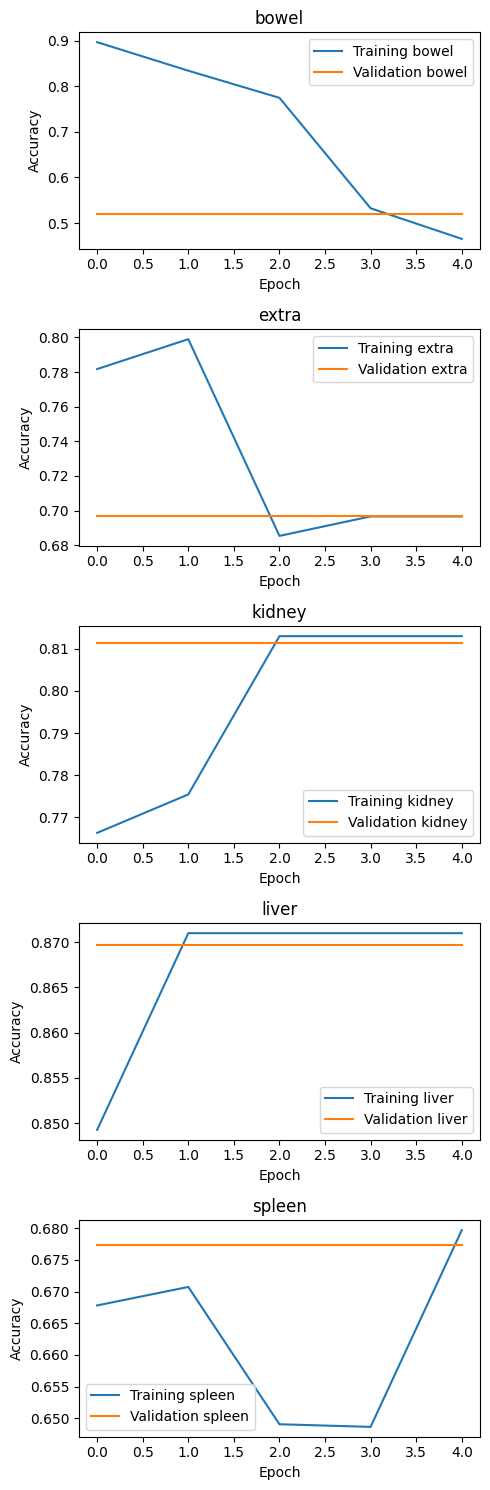

In [18]:
# Create a 3x2 grid for the subplots
fig, axes = plt.subplots(5, 1, figsize=(5, 15))

# Flatten axes to iterate through them
axes = axes.flatten()

# Iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Plot training accuracy
    axes[i].plot(history.history[name + '_accuracy'], label='Training ' + name)
    # Plot validation accuracy
    axes[i].plot(history.history['val_' + name + '_accuracy'], label='Validation ' + name)
    axes[i].set_title(name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()

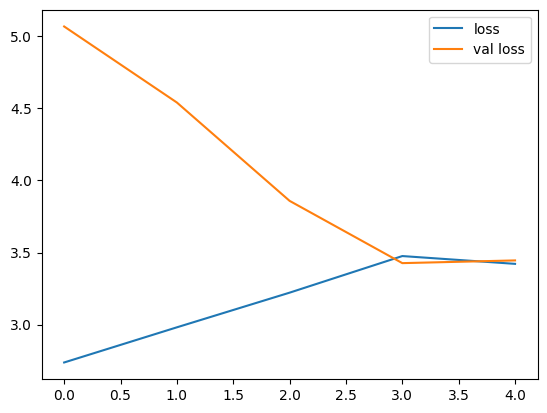

In [19]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [20]:
# store best results
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]

# Find mean accuracy
best_acc = np.mean(
    [best_acc_bowel,
     best_acc_extra,
     best_acc_liver,
     best_acc_kidney,
     best_acc_spleen
])


print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Epoch : {best_epoch}\n')
print('ORGAN Acc:')
print(f'  >>>> {"Bowel".ljust(15)} : {best_acc_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : {best_acc_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : {best_acc_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : {best_acc_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : {best_acc_spleen:.3f}')

>>>> BEST Loss  : 3.427
>>>> BEST Acc   : 0.715
>>>> BEST Epoch : 3

ORGAN Acc:
  >>>> Bowel           : 0.520
  >>>> Extravasation   : 0.697
  >>>> Liver           : 0.870
  >>>> Kidney          : 0.811
  >>>> Spleen          : 0.677


In [21]:
# Save the model
model.save("yolov8-xl-atd.keras")